In [1]:
#Carga de los paquetes
import numpy as np
import pandas as pd
from tqdm import tqdm
import gc ##para colectar lo que no se usa de la memoria
# Algoritmos de regresion
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor 
#Procesamiento
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score
from sklearn.preprocessing import  StandardScaler,  LabelEncoder
#metricas de evaluacion
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#modulos graficos
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


In [2]:
#carga de los datos
datos=pd.read_csv('diamonds_data.csv',low_memory=False)

In [3]:
#En busqueda de valores nulos
print(datos.head(2))
print(datos.info())

   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53930 entries, 0 to 53929
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53930 non-null  float64
 1   cut      53930 non-null  object 
 2   color    53930 non-null  object 
 3   clarity  53930 non-null  object 
 4   depth    53930 non-null  float64
 5   table    53930 non-null  float64
 6   price    53930 non-null  int64  
 7   x        53930 non-null  float64
 8   y        53930 non-null  float64
 9   z        53930 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB
None


Al parecer no hay ningun valor faltante, procedere a hacer un pequeño analisis exploratorio de los datos

EDA e ingenieria de variables

In [4]:
#Medidas de tendencia central
datos.describe()

,carat,depth,table,price,x,y,z
count,53930.000000,53930.000000,53930.000000,53930.000000,53930.000000,53930.000000,53930.000000
mean,0.797976,61.749325,57.457328,3933.054942,5.731236,5.734601,3.538776
std,0.474035,1.432711,2.234578,3989.628569,1.121807,1.142184,0.705729
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5325.000000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


En x,y,z no es posible que haya valores de 0, segun el diccionario de los datos, son medidas cartesianas.

In [5]:
#quiero ver cuantas observaciones tengo con esos valores
print(len(datos[(datos['x']==0) | (datos['y']==0) | (datos['z']==0)]))
print('observaciones con datos erroneos incluidos: '+str(len(datos)))
#podria meterles la media, o un pronostico para lidiar con ellos, pero son relativamente pocos valores.
#Procedere a quitarlos de mis datos
print('quitando valores erroneos')
datos = datos.drop(datos[(datos['x']==0) | (datos['y']==0) | (datos['z']==0)].index)
print('observaciones sin datos erroneos :'+str(len(datos)))

20
observaciones con datos erroneos incluidos: 53930
quitando valores erroneos
observaciones sin datos erroneos :53910


correlacion entre variables

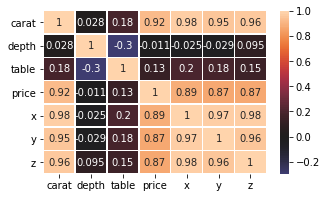

In [6]:
#correlacion grafica
plt.figure(figsize=(5, 3))
sns.heatmap(datos.corr(),annot=True, linewidths=0.5, center=0)

Puedo notar que x,y,z estan muy correlacionadas entre si, tambien con carat, y de hecho carat es la variables mas correlacionada con el precio. Haré uso de ingenieria de variables para incluir en una sola, x,y,z. Les sacaré el volumen de cada diamante.


In [7]:
# Creando la variables volumen
datos['volumen'] = datos.x * datos.y * datos.z

Viendo distribucion cuantilica de las variables numericas, asi como la escala en la que se mueven

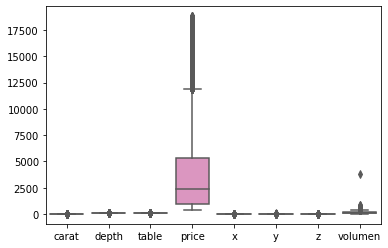

In [8]:
ax = sns.boxplot(data=datos, orient="v", palette="Set2")

Quiero ver si la variable volumen presenta datos atipicos. Para eso vere como se distribuyen sus valores en sus cuantiles, por medio de un diagrama de caja y brazos.



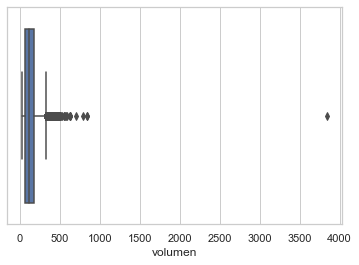

In [9]:
sns.set(style="whitegrid")
ax = sns.boxplot(x=datos["volumen"])

Puedo ver que hay algunos datos que pueden ser clasificados como outliers, sin embargo, hay observaciones en las que su volumen es mayor a 500.
Recordando que la regresion no es robusta a outliers, quiero ver cuantos datos tienen un volumen mayor a 500.
"Pon en un bar a bill gates y en promedio todos son millonarios".Voy a ver cuantas observaciones tienen un volumen mayor a 500


In [10]:
print('observaciones con volumen mayor a 500:')
print(len(datos[datos['volumen']>500]))
print('observaciones con volumen mayor a 1000')
print(len(datos[datos['volumen']>1000]))


observaciones con volumen mayor a 500:
17
observaciones con volumen mayor a 1000
1


Podemos ver que en si, son relativamente pocos datos los que tienen un volumen mayor a 500. Como son pocos, y gano mayor robustez al quitarlos,procederé a retirarlos del dataset.

In [11]:
##Procedere a quitar esas observaciones con un volumen mayor a 500
datos = datos.drop(datos[datos['volumen']>=500].index)
len(datos)

53893

Codificare las variables categoricas para poder hacer un analisis de correlacion con ellas y tambien para que prepararlas para ajustarle un modelo de machine learning. Es necesario ya que un modelo no puede ser alimentado con strings


In [12]:
datos_p=datos.copy()
cat_cols=['cut', 'color', 'clarity']
le = LabelEncoder()
for i in cat_cols :
    datos_p[i] = le.fit_transform(datos_p[i])

Me desharé de las variables de x.y,z ya que tienen una corrrelacion alta entre si, ademas de que la variable volumen captura mejor el efecto en conjunto. Después,veré la correlación entre las variables que me quedan.

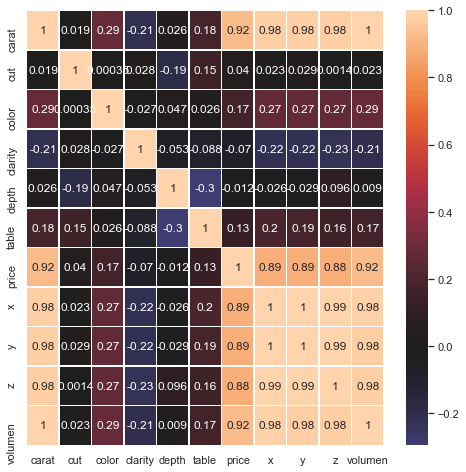

In [25]:
plt.figure(figsize=(8, 8))
sns.heatmap(datos_p.corr(),annot=True, linewidths=0.5, center=0)

Podemos notar que las variables mas correlacionadas con el precio son:carat y volumen. Al parecer, mientras mas grande el diamante, mayor es su precio.

Ya que los datos están limpios, procederé a prepararlos para el modelo.

Dividire los datos, en variables explicativas y variable objetivo. Despues, los dividiré en conjunto de entrenamiento y de test. Por ultimo, estandarizare las variables. ¿Por qué lo hago?, por que me permite hacer comparables variables que estan medidas en diferentes unidades, es decir, mi analisis se vuelve adimensional.

In [14]:
y = datos_p['price']
x = datos_p.drop(['price'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=0)#20% para el test
#estandarizando las variables
std = StandardScaler()
x_train = std.fit_transform(x_train)
x_test = std.transform(x_test)

Las metricas que elegi para evaluar, es el coeficiente de determinacion R2, el error absoluto medio y el error cuadratico medio

Ajuste de Modelos

Decidi ajustarle 3 modelos, GradientBoosting,RandomForest y XGBOOST

In [15]:
R2_ = []
MAE=[]
RMSE=[]
modelos = ['GradientBoosting','RandomForest' ,'XGBOOST']

In [16]:
#funcion para graficar comparacion entre prediccion y real
def grafica(a,b):
    trace0 = go.Scatter(
    y = a,
    x = np.arange(200), 
    mode = 'lines', 
    name = 'Precio Real',
    marker = dict(
    color = 'rgb(10, 150, 50)'))
    trace1 = go.Scatter(
    y = b,
    x = np.arange(200), 
    mode = 'lines', 
    name = 'Precio Predicción',
    line = dict(
        color = 'rgb(110, 50, 140)',
        dash = 'dot'))
    layout = go.Layout(
    xaxis = dict(title = 'Index'), 
    yaxis = dict(title = 'Precio'))
    figure = go.Figure(data = [trace0, trace1], layout = layout)
    return iplot(figure)

GRADIENT BOOSTING

In [17]:
#Primero el Gradient boosting
gbr = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1,max_depth=1, random_state=0, loss='ls',verbose = 1)
gbr.fit(x_train , y_train)
precision = cross_val_score(estimator = gbr, X = x_train, y = y_train, cv = 5,verbose = 1)
y_predgb = gbr.predict(x_test)
print('PUNTAJE : %.4f' % gbr.score(x_test, y_test))
print(precision)
mae = mean_absolute_error(y_test, y_predgb)
rmse = mean_squared_error(y_test, y_predgb)**0.5
r2 = r2_score(y_test, y_predgb)
print('MAE    : %0.2f ' % mae)
print('RMSE   : %0.2f ' % rmse)
print('R2     : %0.2f ' % r2)
MAE.append(mae)
RMSE.append(rmse)
R2_.append(r2)
#grafica(y_test,y_pred)

      Iter       Train Loss   Remaining Time 
         1    13966038.8119            7.99s
         2    12396534.2235            7.49s
         3    11085719.2831            8.98s
         4     9907653.9691            9.46s
         5     8944760.1879            8.96s
         6     8066872.6467            9.44s
         7     7351390.0371           10.50s
         8     6722847.1605           11.54s
         9     6159188.6050           12.34s
        10     5691386.1300           12.67s
        20     3162793.0872           10.88s
        30     2352113.7958            9.77s
        40     2059316.0499            9.60s
        50     1881565.1768            9.77s
        60     1747935.5324            9.84s
        70     1646021.3312            9.90s
        80     1567435.5781           10.11s
        90     1506268.0786           10.25s
       100     1457943.5650           10.43s
       200     1229355.8161            8.41s
       300     1134943.0304            6.67s
       40

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


        20     3168836.6719           13.38s
        30     2357537.9888           13.16s
        40     2064840.6788           12.84s
        50     1886024.7357           11.19s
        60     1752582.8903           10.04s
        70     1650307.8426            9.85s
        80     1571460.6961            9.86s
        90     1510365.7991            9.91s
       100     1461925.1765            9.74s
       200     1232112.8284            7.83s
       300     1136789.9639            6.25s
       400     1092689.9358            5.03s
       500     1071308.8847            4.03s
       600     1059033.4544            3.10s
       700     1051209.7026            2.29s
       800     1045817.6819            1.58s
       900     1041965.7964            0.78s
      1000     1039029.2374            0.00s
      Iter       Train Loss   Remaining Time 
         1    13909643.1645            8.02s
         2    12344093.2199            8.00s
         3    11036299.4588            9.97s
         

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.4s finished


In [18]:
gc.collect()

6469

Regresion con Random Forest

In [19]:
rf = RandomForestRegressor(n_estimators=1200, max_features= 'auto')
rf.fit(x_train , y_train)
precision = cross_val_score(estimator = rf, X = x_train, y = y_train, cv = 5,verbose = 1)
y_predrf = rf.predict(x_test)
print('PUNTAJE : %.4f' % rf.score(x_test, y_test))
print(precision)
mae = mean_absolute_error(y_test, y_predrf)
rmse = mean_squared_error(y_test, y_predrf)**0.5
r2 = r2_score(y_test, y_predrf)
print('MAE    : %0.2f ' % mae)
print('RMSE   : %0.2f ' % rmse)
print('R2     : %0.2f ' % r2)
MAE.append(mae)
RMSE.append(rmse)
R2_.append(r2)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 20.8min finished


PUNTAJE : 0.9815
[0.98037336 0.98040918 0.97971026 0.9806529  0.980947  ]
MAE    : 270.58 
RMSE   : 545.81 
R2     : 0.98 


In [20]:
gc.collect()

140

Regresión con XGBOOST

In [21]:
xgbr=xgb.XGBRegressor(booster='gbtree',objective='reg:linear',n_estimators=1000)
xgbr.fit(x_train , y_train)
accuracies = cross_val_score(estimator = xgbr, X = x_train, y = y_train, cv = 5,verbose = 1)#para hacer validacion cruzada
y_predxg = xgbr.predict(x_test)
print('Puntaje : %.4f' % xgbr.score(x_test, y_test))
print(accuracies)
mae = mean_absolute_error(y_test, y_predxg)
rmse = mean_squared_error(y_test, y_predxg)**0.5
r2 = r2_score(y_test, y_predxg)
print('MAE    : %0.2f ' % mae)
print('RMSE   : %0.2f ' % rmse)
print('R2     : %0.2f ' % r2)
MAE.append(mae)
RMSE.append(rmse)
R2_.append(r2)

[23:32:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[23:32:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:32:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:32:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:33:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:33:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min finished


Puntaje : 0.9818
[0.97933445 0.97902958 0.97783734 0.9795957  0.97977299]
MAE    : 276.15 
RMSE   : 541.44 
R2     : 0.98 


In [22]:
#Comparacion grafica de las predicciones
print('Predicción vs Real GradientBoosting')
print(grafica(y_test,y_predgb))
print('Prediccion vs Real RandomForest')
print(grafica(y_test,y_predrf))
print('Predicción vs Real XGBOOST')
print(grafica(y_test,y_predxg))


Predicción vs Real GradientBoosting


None
Prediccion vs Real RandomForest


None
Predicción vs Real XGBOOST


None


Claramente se ve que el XGBOOST  y el RandomForest tienen valores de prediccion que se ajustan mejor a la forma de los datos reales.

Ahora, viendo en una tabla la comparacion de metricas...

In [23]:
comparacion = pd.DataFrame({'algoritmos' : modelos , 'R2' : R2_,'MAE':MAE,'RMSE':RMSE})
comparacion.sort_values(by='R2' ,ascending=False)

,algoritmos,R2,MAE,RMSE
2,XGBOOST,0.981830,276.152443,541.437208
1,RandomForest,0.981536,270.576969,545.806459
0,GradientBoosting,0.933261,668.687769,1037.673156


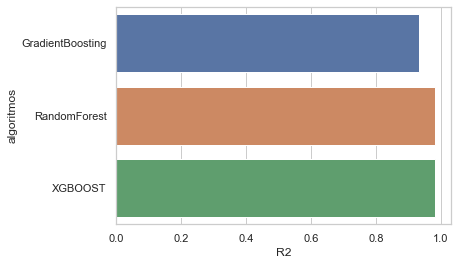

In [24]:
sns.barplot(x='R2' , y='algoritmos' , data=comparacion)

Podemos ver que tanto random forest como xgboost, tuvieron un performance parecido. En este caso, el modelo que eligire es el XGBOOST. Tuvo un RMSE menor y una R2 mayor. XGBOOST es mas eficiente computacionalmente que random forest. Tambien, XGBOOST no presenta el problema de sesgo hacia las categorias con mayores problemas.

Uno de los descubrimientos mas importantes, fue que las caracteristicas que mas influyen en el precio de los diamantes son carat y el volumen.
A su vez, el volumen es una combinacion de x,y,z. Por lo que el tamaño si determina en gran medida el precio de un diamante.
Lo que seguiria, seria poder hacer un tunning de los hiperparametros para poder conseguir un mayor desempeño en los algoritmos. No hubo tiempo para hacerselo, pero seria necesario. 